Roughly reproducing the simulator on the Washington Post
https://www.washingtonpost.com/graphics/2020/world/corona-simulator/

In [10]:
%matplotlib inline

In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as pl
from numpy import random as rd


In [65]:
n_agents = 100
transmission_threshold_distance = 0.01
transmission_factor = 1

speed = 0.01
initial_infections = 1


def initialize_agents(n_agents, initial_infections):
    x_pos = [rd.uniform() for _ in range(n_agents)]
    y_pos = [rd.uniform() for _ in range(n_agents)]

    x_dir = [rd.normal()*speed for _ in range(n_agents)]
    y_dir = [rd.normal()*speed for _ in range(n_agents)]

    agent_order = rd.permutation(n_agents)

    agent_status = [0 for _ in range(n_agents)]
    # status 
    # 0 - uninfected
    # 1 - infected
    # 2 - recovered
    # 3 - mortality

    initial_patients = 1
    # create patient(s) zero
    for agent_index in agent_order[0:initial_patients]:
        agent_status[agent_index]  = 1
        
    agents = pd.DataFrame({'x pos': x_pos, 'y pos': y_pos, 'status': agent_status, 'x dir': x_dir, 'y dir': y_dir})

    return agents

# def update
agents = initialize_agents(n_agents, initial_infections)

print(agents['status'].to_list())# eye-balling that there is one (or initial_infections) agent with status=1 and the rest zero


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [66]:
status_colors = {0: 'blue', 1: 'brown', 2: 'pink', 3: 'black'}
def status_color(status):
    return status_colors[status]

In [69]:
agents['color'] = agents['status'].apply(status_color)

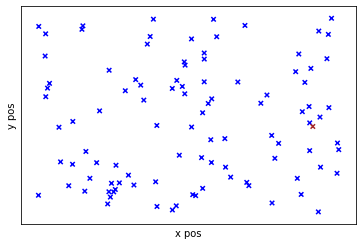

In [77]:
def plot_agents(agents):
    agents.plot.scatter(x='x pos', y='y pos', color=agents['color'], marker='x')
    pl.xticks([])
    
    _ = pl.yticks([])
    
plot_agents(agents)

In [73]:
"""
Two repeating events

1. Update infection statuses
    1a. Transmission 
        1a1. Check whether agents are within transmission distance
        1a2. Determine with infection transmits (v1 assume probability = 1, future model adjust probabilities). 
            Transmission rates/probabilities are relatedc to people's hygiene practices.
            E.g. use of gloves, washing of hands reduces transmission rates.
            
        1a3. Update status
        
    1b. Recovery (vs death)
        
        Update status
    
    1c. Death
        Probability based on factors: 
            age, 
            probability of being a smoker, 
            hospital load: hospital_capacity vs (current infected * probability of being hospitalized)
                probability of being covered = (USA: x %, rest of OECD: 1)
            +random factor
        
        
2. Movement    
        Update location of each agent
    Factors:
        social isolation: some % of agents do not move         


"""
None

In [90]:
def agents_are_close(threshold, agent1_x_pos, agent1_y_pos, agent2_x_pos, agent2_y_pos):
    
    distance = np.sqrt( (agent1_x_pos-agent2_x_pos) ** 2 + (agent1_y_pos-agent2_y_pos) ** 2 )
    
    return distance <= threshold


# test:
if not agents_are_close( 0.1, 0.8, 0.3, 0.81, 0.28 ):
    raise(ValueError("Distance function not working")) # Not really a value error. This should be implemented as a unit test.

In [104]:
def transmit_disease(agents_curr):
    agents = agents_curr.copy()
    
    agents.loc[:,'update as infected'] = False

    # update infected status
    for agent1_index in range(n_agents):
        # 
        agent1 = agents.iloc[agent1_index]

        for agent2_index in range(n_agents)[:agent1_index]:
            agent2 = agents.iloc[agent2_index]
            
            # future version, do a self merge
            if agents_are_close( transmission_threshold_distance, agent1['x pos'], agent1['y pos'], agent2['x pos'], agent2['y pos']) \
                and rd.uniform() < transmission_factor \
                and agent1['status'] == 0 \
                and agent2['status'] == 1: # future, agent2 infected days between min and max 
                    agents.loc[agent1_index,'update as infected'] = True
                    agents.loc[agent2_index,'update as infected'] = True

                    # future, update infection days count

    # Assign infected status
    agents.loc[agents['update as infected'],'status'] = 1
    
    return agents

In [131]:
#agents.head()
agents

print(agents.loc[agents['status']==1,:])

       x pos     y pos  status     x dir     y dir  color
44  0.909564  0.442054       1 -0.009855  0.007571  brown


In [98]:
# agents

In [106]:
#transmit_disease(agents)

In [108]:
# agent_state = []
# agent_state.append(agents)
# agent_state.append(transmit_disease(agents))

# print(agent_state[1].loc[agent_state[1]['status']==1,:])

In [133]:
adjust_outofrange = lambda pos, bounds: pos if (pos <= bounds[1] and pos >= bounds[0]) else (pos-1 if pos>bounds[1] else pos+1)

# def new_location(x_new, y_new, bounds):
#     # future, x1, y1, x2, y2, x_velocity, y_velocity
    
#     return (adjust_outofrange(x_new, [0,1]), adjust_outofrange(y_new, [0,1])) # too much engineering? Setting up for future new_location which could bound agents of bounds and other agents.
 
def move_agents(agents_orig):
    
    agents = agents_orig.copy()
    
    agents['x pos'] = agents['x pos'] + agents['x dir']
    agents['y pos'] = agents['y pos'] + agents['y dir']
    
    # update if outside of range - rather than "bouncing" off other agents, we assume that the continue to move within the space starting from the other extremee.
    agents['x pos'] = agents['x pos'].apply(lambda x: adjust_outofrange(x, [0,1]) )
    agents['y pos'] = agents['y pos'].apply(lambda x: adjust_outofrange(x, [0,1]) )
        
    return agents

In [ ]:
# run simulation (100 iterations)
n_periods = 1000

agent_state = []
agent_state.append(agents)
for period_i in range(n_periods):    
    # transmit
    agent_state.append(transmit_disease(agent_state[-1]))
                       
    # move - reuse
    agent_state[-1] = move_agents(agent_state[-1])             
                       


In [ ]:
print(agent_state[-1].loc[agent_state[-1]['status']==1,:])

In [ ]:
import time

# UPDATE GRAPHIC        
for period in range(len(agent_state):
    plot_agents(agent_state[period])
    pl.draw()
    time.sleep(1)


In [ ]:
plot_agents(agent_state)